## 載入所需的 Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

---
## 載入資料

In [101]:
# read data from spam.csv
sms_data = pd.read_csv('spam.csv', encoding='latin-1') # UTF-8 無法處理檔案文字
sms_data = sms_data.loc[:, ['v1', 'v2']] # 清掉後面的 NaN
sms_data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check how many spams and hams
sms_data.groupby('v1').count()

,v2
v1,
ham,4825
spam,747


In [3]:
# Answer

,content
label,
ham,4825
spam,747


In [107]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1

sms_data['v1'] = sms_data['v1'].apply(lambda x: 0 if x=='ham' else 1)
sms_data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


---
## 切分資料
* 將資料依據 label 比例切分為 training 與 testing data

In [53]:
ham = sms_data[sms_data.loc[:, 'v1'] == 0]
ham = ham.reset_index(drop=True)
ham_train = ham.loc[:len(ham)*0.8, :]
ham_test = ham.loc[len(ham)*0.8:, :]

spam = sms_data[sms_data.loc[:, 'v1'] == 1]
spam = spam.reset_index(drop=True)
spam_train = spam.loc[:len(spam)*0.8, :]
spam_test = spam.loc[len(spam)*0.8:, :]

In [54]:
len(ham_train)/len(ham), len(ham_test)/len(ham)

(0.8002072538860103, 0.2)

In [55]:
len(spam_train)/len(spam), len(spam_test)/len(spam)

(0.8005354752342704, 0.1994645247657296)

In [56]:
sms_train = ham_train.append(spam_train)
sms_test = ham_test.append(spam_test)

In [57]:
print(sms_train.groupby("v1").count())
print(sms_test.groupby("v1").count())

      v2
v1      
0   3861
1    598
     v2
v1     
0   965
1   149


#### 使用 sklearn 分組

In [108]:
sms_train, sms_test = train_test_split(sms_data, test_size=0.2, stratify=sms_data.v1)
sms_train.reset_index(inplace=True, drop=True)
sms_test.reset_index(inplace=True, drop=True)

print(sms_train.groupby("v1").count())
print(sms_test.groupby("v1").count())

      v2
v1      
0   3859
1    598
     v2
v1     
0   966
1   149


---
## 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [113]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)): 
        # make all content to lowercase
        df['v2'][i] = df['v2'][i].lower()

        # remove all punctuations
        df['v2'][i] = ' '.join(word for word in re.findall(r'[a-zA-Z]+', df['v2'][i]) if word != '')
    
    return df

In [114]:
processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head());

Train:
   v1                                                 v2
0   1  freemsg fancy a flirt reply date now join the ...
1   0                       ok i asked for money how far
2   0              lt gt ish minutes was minutes ago wtf
3   0  i am thinking of going down to reg for pract l...
4   0  oops my phone died and i didn t even know yeah...
Test:
   v1                                                 v2
0   0  how its a little difficult but its a simple wa...
1   0                    wat time do u wan meet me later
2   0                        thanx e brownie it s v nice
3   0  all done all handed in celebrations in full sw...
4   0  if you were are free i can give otherwise nall...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [115]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7708

---
## TF-IDF
* 可以發現種共有 7708 個字詞，這裡使用 TF-IDF 將來選取最高分的前 2000 個字詞
(若忘記的學員可參考先前 TF-IDF 課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [117]:
vectorizer = TfidfVectorizer(max_features=2000) # 取前兩千名
vectorizer.fit(x_train)
tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 51314 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12149 stored elements in Compressed Sparse Row format>)

---
## 建立共現矩陣

In [120]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    # initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(len(vocab_list), len(vocab_list)), dtype=np.int32)
    
    for idx, sms in enumerate(corpus):
        sms = sms.split()
        sms_ids = [word2idx[word] for word in sms if word in vocab_list] # tokenize
        
        for center_i, center_word_id in enumerate(sms_ids):
            context_ids = sms_ids[max(0, center_i - window_size):center_word_id]
            context_len = len(context_ids)
            
            for left_i, left_word_id in enumerate(context_ids):
                
                if use_weighting:
                    distance = context_len - left_i
                    increment = 1./float(distance)
                
                else:
                    increment = 1
                    
                co_matrix[center_word_id, left_word_id] += increment
                co_matrix[left_word_id, center_word_id] += increment

        if verbose:
            if idx != 0 and idx % 500 == 0:
                print(f"finishing {idx+1}/{len(corpus)}")
    
    print("Done")
    
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        np.fill_diagonal(co_matrix, 1.)
        
    return co_matrix

In [122]:
co_matrix = create_co_matrix(
                x_train, 
                vectorizer.get_feature_names(),
                vectorizer.vocabulary_,
                window_size=3, 
                use_weighting=True, 
                verbose=True
            )

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

---
## 建立 PPMI 矩陣

In [123]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    
    count = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                count += 1
                if count % 10 == 0 or count == total:
                    print(f"{count}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


array([[16.671762,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  8.027906,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  1.257044, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 12.027906,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  6.582974,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
        11.057053]], dtype=float32)

---
## 使用 SVD 降維
* 利用 sklearn 中的 `TruncatedSVD` 對 co-occurrence matrix 進行降維，並利用 `variance` 來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用 SVD 對 PPMI 進行降維)

Number of components = 10 and explained variance = 0.592525968145016
Number of components = 20 and explained variance = 0.6756202002534482
Number of components = 30 and explained variance = 0.7254040334786919
Number of components = 40 and explained variance = 0.760274675006062
Number of components = 50 and explained variance = 0.7866640612910266
Number of components = 60 and explained variance = 0.8077652950849683
Number of components = 70 and explained variance = 0.8256725074888707
Number of components = 80 and explained variance = 0.8410907467027866
Number of components = 90 and explained variance = 0.8544193386948878
Number of components = 100 and explained variance = 0.8662064159165599
Number of components = 110 and explained variance = 0.876605980362211
Number of components = 120 and explained variance = 0.8856906514783541
Number of components = 130 and explained variance = 0.893710820779177
Number of components = 140 and explained variance = 0.900763134857525


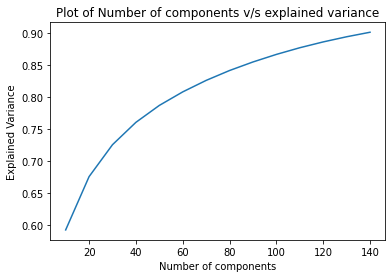

In [124]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print(f"Number of components = {dim} and explained variance = {svd.explained_variance_ratio_.sum()}")
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [125]:
# choose 140 as final dimension to reduce to
svd = TruncatedSVD(n_components=140)
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)

---
## 使用 KNN 模型進行分類
* 在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [129]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

In [130]:
word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)

doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 108 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 953 doesn't contain word in vocab_list
hanks lotsly


document 1387 doesn't contain word in vocab_list
tf p


document 1544 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 1846 doesn't contain word in vocab_list
k k congratulation


document 2458 doesn't contain word in vocab_list
u


document 2719 doesn't contain word in vocab_list
erutupalam thandiyachu


document 2905 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 3137 doesn't contain word in vocab_list



document 3254 doesn't contain word in vocab_list



document 3285 doesn't contain word in vocab_list
ringtoneking


document 3327 doesn't contain word in vocab_list
g w r


document 3903 doesn't contain word in vocab_list
east coast


document 17 doesn't contain word in vocab_list



document 729 doesn't contain word in vocab_list
beerage




### KNN 近鄰分類法

In [131]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = knn.predict(doc_vec_test)

In [132]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9783978397839784
train acc: 0.9568733153638814
